In [121]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import accuracy_score 


data collection & preprocessing 

In [122]:
df=pd.read_csv('spam.csv', encoding = "ISO-8859-1")

In [123]:
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [124]:
df.isnull().sum()

v1               0
v2               0
Unnamed: 2    5522
Unnamed: 3    5560
Unnamed: 4    5566
dtype: int64

In [125]:
data= df.where((pd.notnull(df)),'')  # replacing the null value with blank space 

In [126]:
data.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",,,
1,ham,Ok lar... Joking wif u oni...,,,
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,,,
3,ham,U dun say so early hor... U c already then say...,,,
4,ham,"Nah I don't think he goes to usf, he lives aro...",,,


In [127]:
data.isnull().sum()

v1            0
v2            0
Unnamed: 2    0
Unnamed: 3    0
Unnamed: 4    0
dtype: int64

In [128]:
data.shape 

(5572, 5)

In [129]:
data.duplicated().sum()

403

In [130]:
data = data.drop_duplicates(keep='first')

In [131]:
data.shape 

(5169, 5)

In [132]:
data.columns

Index(['v1', 'v2', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], dtype='object')

In [133]:
data.drop(columns=['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], inplace=True, axis=1) # removing unwanted columns

In [134]:
# renaming columns
data.rename(columns={'v1': 'Category', 'v2' :'Message '}, inplace=True)

In [135]:
data['category'] = data.Category.map({'ham' : 0, 'spam' : 1})

In [136]:
data.drop('Category', inplace=True, axis=1) #removing extra caregory column

In [137]:
data.head()

,Message,category
0,"Go until jurong point, crazy.. Available only ...",0
1,Ok lar... Joking wif u oni...,0
2,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,U dun say so early hor... U c already then say...,0
4,"Nah I don't think he goes to usf, he lives aro...",0


# EDA

In [138]:
data['category'].value_counts()

0    4516
1     653
Name: category, dtype: int64

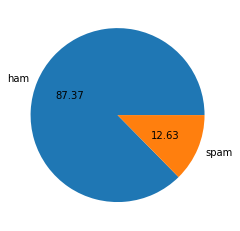

In [139]:
import matplotlib.pyplot as plt
plt.pie(data['category'].value_counts(), labels=['ham','spam'],autopct="%0.2f")
plt.show()

data is imbalanced

In [140]:
import nltk

In [141]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\amres\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [142]:
data.columns

Index(['Message ', 'category'], dtype='object')

In [143]:
data = data.rename(columns={'Message ': 'Message'})

In [144]:
#counting no of characters

In [145]:
data['No_Of_Character']=data['Message'].apply(len)

In [146]:
#counting no of words

In [147]:
data['Num_Of_Words']=data['Message'].apply(lambda x: len(nltk.word_tokenize(x)))

In [148]:
#nuber of sentances 

In [149]:
data['number_of_sentences']=data['Message'].apply(lambda x: len(nltk.sent_tokenize(x)))

In [150]:
data.head()

,Message,category,No_Of_Character,Num_Of_Words,number_of_sentences
0,"Go until jurong point, crazy.. Available only ...",0,111,24,2
1,Ok lar... Joking wif u oni...,0,29,8,2
2,Free entry in 2 a wkly comp to win FA Cup fina...,1,155,37,2
3,U dun say so early hor... U c already then say...,0,49,13,1
4,"Nah I don't think he goes to usf, he lives aro...",0,61,15,1


In [151]:
data.describe()

,category,No_Of_Character,Num_Of_Words,number_of_sentences
count,5169.000000,5169.000000,5169.000000,5169.000000
mean,0.126330,78.977945,18.453279,1.947185
std,0.332253,58.236293,13.324793,1.362406
min,0.000000,2.000000,1.000000,1.000000
25%,0.000000,36.000000,9.000000,1.000000
50%,0.000000,60.000000,15.000000,1.000000
75%,0.000000,117.000000,26.000000,2.000000
max,1.000000,910.000000,220.000000,28.000000


<AxesSubplot:xlabel='No_Of_Character', ylabel='Count'>

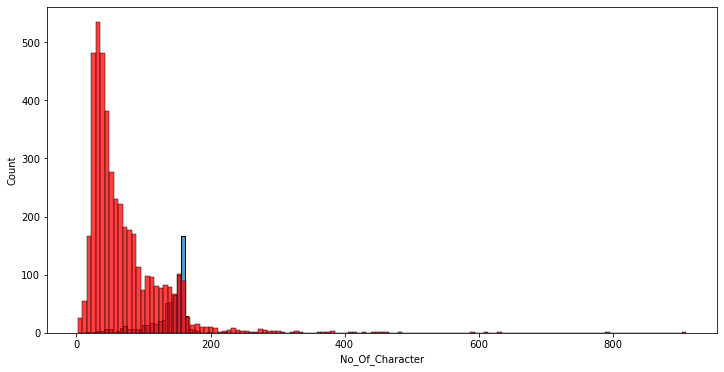

In [152]:
plt.figure(figsize=(12,6))
sns.histplot(data[data['category']==1]['No_Of_Character'])
sns.histplot(data[data['category']==0]['No_Of_Character'],color='red')


Insights: as we see Spam have more no of characters

<AxesSubplot:xlabel='Num_Of_Words', ylabel='Count'>

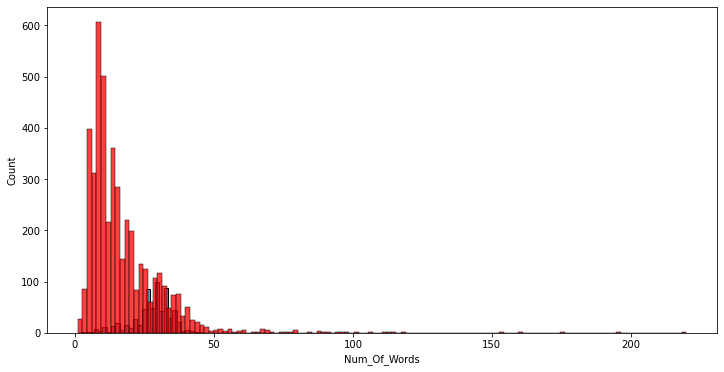

In [153]:
plt.figure(figsize=(12,6))
sns.histplot(data[data['category']==1]['Num_Of_Words'])
sns.histplot(data[data['category']==0]['Num_Of_Words'],color='red')

Insights: as we see Spam have more no of words

<AxesSubplot:>

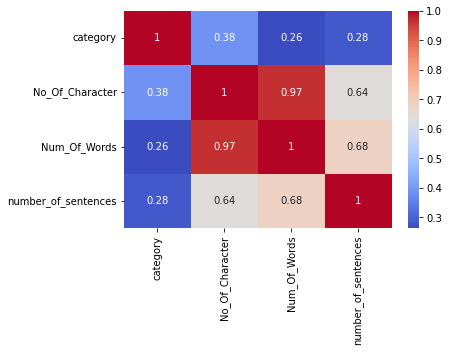

In [154]:
sns.heatmap(data.corr(), annot=True, cmap='coolwarm')

# Data Preprocessing 

In [155]:
def text_transform(text):
    text=text.lower()
    text=nltk.word_tokenize(text)
    

In [156]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\amres\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\amres\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\amres\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\amres\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [157]:
def preprocess_text(text):
    # convert to lowercase
    text = text.lower()
    
    # remove special characters
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    
    # tokenize the text
    tokens = word_tokenize(text)
    
    # remove stop words
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [token for token in tokens if token not in stop_words]
    
    # lemmatize the tokens
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]
    
    # join the tokens back into a single string with spaces
    preprocessed_text = ' '.join([token + ' ' for token in lemmatized_tokens])
    
    return preprocessed_text

In [158]:
text = "question(std txt rate)"

# tokenize the text and split tokens based on parentheses
tokens = re.findall(r'\b\w+\b|[()]', text)

# print the tokens
print(tokens)

['question', '(', 'std', 'txt', 'rate', ')']


In [159]:
data['tranformed_message']=data['Message'].apply(preprocess_text)

In [160]:
data.head()

,Message,category,No_Of_Character,Num_Of_Words,number_of_sentences,tranformed_message
0,"Go until jurong point, crazy.. Available only ...",0,111,24,2,go jurong point crazy available bugis n ...
1,Ok lar... Joking wif u oni...,0,29,8,2,ok lar joking wif u oni
2,Free entry in 2 a wkly comp to win FA Cup fina...,1,155,37,2,free entry 2 wkly comp win fa cup fina...
3,U dun say so early hor... U c already then say...,0,49,13,1,u dun say early hor u c already say
4,"Nah I don't think he goes to usf, he lives aro...",0,61,15,1,nah dont think go usf life around though


In [161]:
from wordcloud import WordCloud
wc=WordCloud(width=1600, height=1600,min_font_size=10,max_words=100,background_color='white',contour_width=3, contour_color='steelblue')

In [162]:
ham_wc=wc.generate(data[data['category']==0]['tranformed_message'].str.cat(sep=" "))

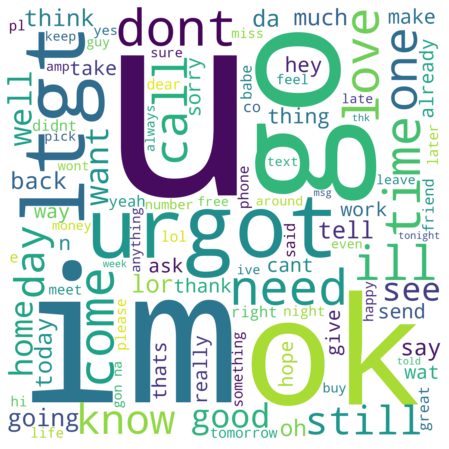

In [163]:
plt.figure(figsize=(8, 8))
plt.imshow(ham_wc, interpolation='bilinear')
plt.axis('off')
plt.show()

In [164]:
spam_wc=wc.generate(data[data['category']==1]['tranformed_message'].str.cat(sep=" "))

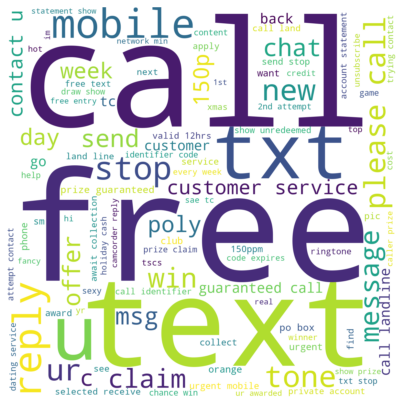

In [165]:
plt.figure(figsize=(7, 8))
plt.imshow(spam_wc, interpolation='bilinear')
plt.axis('off')
plt.show()

In [166]:
spam_corpus=[]
for msg in data[data['category']==1]['tranformed_message'].tolist():
    for word in msg.split():
        spam_corpus.append(word)

In [167]:
len(spam_corpus)

10813

C:\Users\amres\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


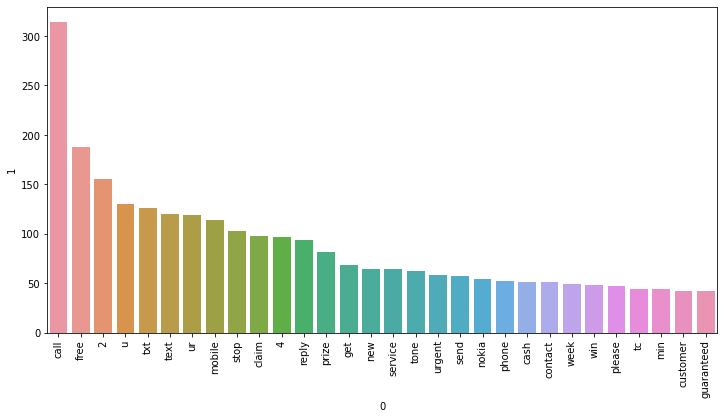

In [168]:
from collections import Counter
fig, ax = plt.subplots(figsize=(12, 6))
ax.set_xlabel('No of words')
ax.set_ylabel('Top 30 words in spam')
sns.barplot(pd.DataFrame(Counter(spam_corpus).most_common(30))[0], pd.DataFrame(Counter(spam_corpus).most_common(30))[1])
plt.xticks(rotation='vertical')
plt.show()

In [169]:
x=data['tranformed_message']

In [170]:
y=data['category']

In [171]:
X_train,X_test,Y_train,Y_test= train_test_split(x,y,test_size=0.2,random_state=20)

In [172]:
#tranform the test data into feature vectors that can be used as input to the Logistic regression 

feature_extraction=TfidfVectorizer(max_features=3000) 
feature_extraction

TfidfVectorizer(max_features=3000)

In [173]:
#spliting the data

In [174]:
print(x.shape)  #shapes of X_train,X_test,Y_train,Y_test
print(y.shape)
print(X_train.shape)
print(X_test.shape)

(5169,)
(5169,)
(4135,)
(1034,)


In [175]:
X_train_features=feature_extraction.fit_transform(X_train).toarray()   #model fiting 
X_test_features=feature_extraction.transform(X_test).toarray()



In [176]:
Y_test=Y_test.astype('int')  #changing values of test data from object to integer 
Y_train=Y_train.astype('int')

# Training the model

In [177]:
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score

classifiers = {
    "Decision Tree": DecisionTreeClassifier(max_depth=5),
    "Naive Bayes": GaussianNB(),
    "Logistic Regression": LogisticRegression(solver='liblinear', penalty='l1'),
    "Multinominal Bayes" : MultinomialNB(alpha=0.1),
    "Bar Naive Bayes":BernoulliNB(),
    "Support vecctor classifiers" : SVC(kernel='sigmoid', gamma=1.0),
    "KNN" : KNeighborsClassifier(),
    "rfc" : RandomForestClassifier(n_estimators=50, random_state=2),
    "AdaBoost" : AdaBoostClassifier(n_estimators=50, random_state=2),
    "GradientBoosting" : GradientBoostingClassifier(n_estimators=50,random_state=2),
    "xgb" : XGBClassifier(n_estimators=50,random_state=2)
}

# Train and evaluate each classifier
for name, clf in classifiers.items():
    clf.fit(X_train_features,Y_train)
    y_pred = clf.predict(X_test_features)
    acc = accuracy_score(Y_test, y_pred)
    pre = precision_score(Y_test, y_pred)
    print(f"{name}: accuracy = {acc*100}, precision = {pre*100} ")

Decision Tree: accuracy = 91.77949709864603, precision = 85.88235294117646 
Naive Bayes: accuracy = 86.26692456479691, precision = 50.8 
Logistic Regression: accuracy = 94.97098646034816, precision = 91.22807017543859 
Multinominal Bayes: accuracy = 98.25918762088975, precision = 99.23076923076923 
Bar Naive Bayes: accuracy = 97.38878143133462, precision = 100.0 
Support vecctor classifiers: accuracy = 97.38878143133462, precision = 94.07407407407408 
KNN: accuracy = 89.16827852998065, precision = 100.0 
rfc: accuracy = 97.48549323017409, precision = 100.0 
AdaBoost: accuracy = 96.71179883945842, precision = 99.12280701754386 
GradientBoosting: accuracy = 94.48742746615088, precision = 97.84946236559139 
xgb: accuracy = 96.22823984526111, precision = 98.1981981981982 


In [178]:
#hyperparameter

In [185]:
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB

# Define the pipeline with TfidfVectorizer and MultinomialNB
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', MultinomialNB())
])

# Define the hyperparameter grid to search over
hyperparameters = {
    'tfidf__max_features': [1000,2000,3000,5000],
    'clf__alpha': [0.1, 1.0, 10.0]
}

# Perform the grid search using cross-validation
grid_search = GridSearchCV(pipeline, hyperparameters, cv=5, scoring='precision')

# Fit the grid search to the training data
grid_search.fit(X_train, Y_train)

# Print the best hyperparameters and validation score
print("Best hyperparameters: ", grid_search.best_params_)
print("Validation score: ", grid_search.best_score_)


Best hyperparameters:  {'clf__alpha': 10.0, 'tfidf__max_features': 1000}
Validation score:  1.0


In [182]:
from sklearn.metrics import accuracy_score,confusion_matrix,precision_score

gnb = GaussianNB()
mnb = MultinomialNB(alpha=0.1)
bnb = BernoulliNB(alpha=0.1)

In [186]:
#GaussianNB
from sklearn.model_selection import cross_val_score
cv_scores = cross_val_score(gnb, X_train_features, Y_train, cv=5, scoring='precision')
gnb.fit(X_train_features,Y_train)
y_pred1 = gnb.predict(X_test_features)
print('Accuracy on training data: ',accuracy_score(Y_test,y_pred1)*100)
print(confusion_matrix(Y_test,y_pred1))
print('Precision on training data: ',precision_score(Y_test,y_pred1)*100)
print("Cross-validation precision score: {:.2f}%".format(cv_scores.mean() * 100))

Accuracy on training data:  86.26692456479691
[[765 123]
 [ 19 127]]
Precision on training data:  50.8
Cross-validation precision score: 51.85%


In [187]:
from sklearn.model_selection import cross_val_score
cv_scores = cross_val_score(mnb, X_train_features, Y_train, cv=5, scoring='precision')

mnb.fit(X_train_features,Y_train)
y_pred2 = mnb.predict(X_test_features)
# Print accuracy and confusion matrix
print('Accuracy on test data: {:.2f}%'.format(accuracy_score(Y_test,y_pred2)*100))
print(confusion_matrix(Y_test,y_pred2))
# Print precision on test data
print('Precision on test data: {:.2f}%'.format(precision_score(Y_test,y_pred2)*100))
print("Cross-validation precision score: {:.2f}%".format(cv_scores.mean() * 100))

Accuracy on test data: 98.26%
[[887   1]
 [ 17 129]]
Precision on test data: 99.23%
Cross-validation precision score: 95.81%


In [188]:
cv_scores = cross_val_score(bnb, X_train_features, Y_train, cv=5, scoring='precision')
bnb.fit(X_train_features,Y_train)
y_pred3 = bnb.predict(X_test_features)
print('Accuracy on training data: ',accuracy_score(Y_test,y_pred3)*100)
print(confusion_matrix(Y_test,y_pred3))
print('Precision on training data: ',precision_score(Y_test,y_pred3)*100)
print("Cross-validation precision score: {:.2f}%".format(cv_scores.mean() * 100))

Accuracy on training data:  98.54932301740811
[[888   0]
 [ 15 131]]
Precision on training data:  100.0
Cross-validation precision score: 97.71%


BinomialNB give best accuracy 

# Predictive System

In [189]:
input_mail=["Want explicit SEX in 30 secs? Ring 02073162414 now! Costs 20p/min Gsex POBOX 2667 WC1N 3XX"] 
feature_ext=feature_extraction.transform(input_mail) 
predict_mail= mnb.predict(feature_ext)
print(predict_mail)

if predict_mail[0]==1:
  print ('ham')
if predict_mail[0]==0:
  print ('spam')

[1]
ham


In [190]:

import pickle
pickle.dump(feature_extraction,open('vectorizer.pkl','wb'))
pickle.dump(bnb,open('model.pkl','wb'))
